## Train, Test and Evaluate

### Train the Data

In [3]:
import os 
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay 
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import torch 
import torch.nn as nn 
import torch.optim as optim 
from torch.utils.data import DataLoader, Dataset
import joblib

In [4]:
# Path to directory 
file_path = 'pre_process_dataset.csv' 

dataset = pd.read_csv(file_path) 
dataset.head()

,p_num,hour,minute,hour_sin,hour_cos,minute_sin,minute_cos,bg-5:55,bg-5:50,bg-5:45,...,activity-0:40,activity-0:35,activity-0:30,activity-0:25,activity-0:20,activity-0:15,activity-0:10,activity-0:05,activity-0:00,bg+1:00
0,0,6,10,1.000000,6.123234e-17,0.866025,0.500000,0.252604,0.273438,0.289062,...,2,2,2,2,2,2,2,2,2,0.437500
1,0,6,25,1.000000,6.123234e-17,0.500000,-0.866025,0.291667,0.256510,0.292969,...,2,2,2,2,2,2,2,2,2,0.414062
2,0,6,40,1.000000,6.123234e-17,-0.866025,-0.500000,0.337240,0.242188,0.273438,...,2,2,2,2,2,2,2,2,2,0.519531
3,0,6,55,1.000000,6.123234e-17,-0.500000,0.866025,0.378906,0.236979,0.253906,...,2,2,2,2,2,2,2,2,2,0.492188
4,0,7,10,0.965926,-2.588190e-01,0.866025,0.500000,0.415365,0.252604,0.242188,...,2,2,2,2,2,2,2,2,2,0.410156


### Separate the dataset as Input and Output Features

In [12]:
# Define the target column 
target_col = 'bg+1:00' 

# Separate input features (all columns except the target) 
X = dataset.drop(columns=[target_col]).values # input features as NumPy array 

# Separate output feature (target column) 
y = dataset[target_col].values # Target as NumPy array 

# Split the data into 80% training and 20% testing 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
# Custom dataset
class TransformerDataset(Dataset): 
    def __init__(self, inputs, targets): 
        self.inputs = torch.tensor(inputs, dtype=torch.float32) 
        self.targets = torch.tensor(targets, dtype=torch.float32) 
    
    def __len__(self): 
        return len(self.inputs) 

    def __getitem__(self, idx): 
        return self.inputs[idx], self.targets[idx] 

In [10]:
# Create PyTorch datasets 
train_dataset = TransformerDataset(X_train, y_train) 
test_dataset = TransformerDataset(X_test, y_test) 

In [12]:
# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True) 
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False) 

In [14]:
class Transformer(nn.Module):
    def __init__(self, input_dim, embed_dim, num_heads, num_layers, dropout=0.1):
        super(Transformer, self).__init__() 

        # Embedding Layer 
        self.embedding = nn.Linear(input_dim, embed_dim) 

        # Transformer Encoder 
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, 
            nhead=num_heads, 
            dropout=dropout, 
            dim_feedforward=embed_dim*4 
        )

        # Transformer Encoder 
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Fully Connected Output Layer 
        self.fc = nn.Linear(embed_dim, 1) # Output is 1D for Regression 

    def forward(self, x): 
        # Ensure x has 3 dimensions (batch_size, seq_len, input_dim) 
        if x.dim() == 2: 
            x = x.unsqueeze(1) 
            
        # Input shape: (batch_size, seq_len, input_dim) 
        x = self.embedding(x) 
        x = x.permute(1,0,2) 
        x = self.transformer_encoder(x) 
        x = x.mean(dim=0) 
        x = self.fc(x) 
        return x 

In [16]:
# Model Configuration 
input_dim = X_train.shape[1] # Number of input features 
embed_dim = 192 # Embedding dimension (Must be divisble by num_heads) 
num_heads = 12 # Number of attention heads 
num_layers = 3 # Number Transformer Layers 
dropout = 0.1 

# Instantiate the model 
model = Transformer(input_dim, embed_dim, num_heads, num_layers, dropout) 

# Define Loss Function and Optimizer 
criterion = nn.MSELoss() # Mean Squared Error 
optimizer = optim.Adam(model.parameters(), lr=0.001) 

# Move model to GPU if available 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
model.to(device) 

C:\Users\chamr\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Transformer(
  (embedding): Linear(in_features=511, out_features=192, bias=True)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=192, out_features=192, bias=True)
        )
        (linear1): Linear(in_features=192, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=768, out_features=192, bias=True)
        (norm1): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (fc): Linear(in_features=192, out_features=1, bias=True)
)

In [18]:
def train_model(model, train_loader, criterion, optimizer, num_epochs=20): 
    model.train() # Set model to training mode 
    for epoch in range(num_epochs): 
        total_loss = 0.0 
        for inputs, targets in train_loader: 
            # Move data to device
            inputs, targets = inputs.to(device), targets.to(device)  

            # Forward pass 
            outputs = model(inputs) 
            loss = criterion(outputs.squeeze(), targets) 

            # Backward pass and optimization
            optimizer.zero_grad() 
            loss.backward()
            optimizer.step() 

            total_loss += loss.item() 

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader):.4f}")

In [20]:
# Train the model 
train_model(model, train_loader, criterion, optimizer) 

Epoch 1/20, Loss: 0.0222
Epoch 2/20, Loss: 0.0104
Epoch 3/20, Loss: 0.0090
Epoch 4/20, Loss: 0.0085
Epoch 5/20, Loss: 0.0082
Epoch 6/20, Loss: 0.0079
Epoch 7/20, Loss: 0.0078
Epoch 8/20, Loss: 0.0076
Epoch 9/20, Loss: 0.0076
Epoch 10/20, Loss: 0.0074
Epoch 11/20, Loss: 0.0073
Epoch 12/20, Loss: 0.0073
Epoch 13/20, Loss: 0.0073
Epoch 14/20, Loss: 0.0072
Epoch 15/20, Loss: 0.0072
Epoch 16/20, Loss: 0.0072
Epoch 17/20, Loss: 0.0071
Epoch 18/20, Loss: 0.0071
Epoch 19/20, Loss: 0.0070
Epoch 20/20, Loss: 0.0070


In [22]:
# Save the Model 
torch.save(model.state_dict(), "transformer_model.pth") 

In [24]:
# Re-load the model 
model.load_state_dic(torch.load("transformer_model.pth"))

AttributeError: 'Transformer' object has no attribute 'load_state_dic'

In [26]:
# Evaluation 
def evaluate_model(model, test_loader, criterion):
    model.eval() # Set model to evaluation mode 
    total_loss = 0.0 
    with torch.no_grad(): 
        for inputs, targets in test_loader: 
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs) 
            loss = criterion(outputs.squeeze(), targets) 
            total_loss += loss.item() 
    print(f"Test Loss: {total_loss/len(test_loader):.4f}") 
    

In [28]:
# Evalute the model
evaluate_model(model, test_loader, criterion) 

Test Loss: 0.0076


### Use LSTM Model 

In [16]:
# Custom dataset
class LSTMDataset(Dataset): 
    def __init__(self, inputs, targets): 
        self.inputs = torch.tensor(inputs, dtype=torch.float32).unsqueeze(1)  
        self.targets = torch.tensor(targets, dtype=torch.float32).unsqueeze(1)  
    
    def __len__(self): 
        return len(self.inputs) 

    def __getitem__(self, idx): 
        return self.inputs[idx], self.targets[idx] 

In [46]:
# Write and evalute LSTM model 
class LSTMModel(nn.Module): 
    def __init__(self, input_size, hidden_size=100, output_size=1, num_layers=3, dropout_rate=0.1): 
        super(LSTMModel, self).__init__() 
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_rate)
        self.fc = nn.Linear(hidden_size, output_size) 

    def forward(self, x): 
        out, _ = self.lstm(x)
        out = self.fc(out[:,-1,:]) 
        return out 

In [48]:
# Training function 
def LSTM_train_model(model, train_loader, criterion, optimizer, epochs=20): 
    for epoch in range(epochs): 
        model.train()
        train_loss = 0.0 
        for X_batch, y_batch in train_loader: 
            optimizer.zero_grad() 
            outputs = model(X_batch) 
            loss = criterion(outputs, y_batch) 
            loss.backward() 
            optimizer.step() 
            train_loss += loss.item() * X_batch.size(0) 
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss/len(train_loader.dataset):.4f}") 

# Evaluate the model 
def LSTM_evaluate_model(model, test_loader, criterion): 
    test_loss = 0.0 
    model.eval() 
    with torch.no_grad(): 
        for X_batch, y_batch in test_loader: 
            outputs = model(X_batch) 
            loss = criterion(outputs, y_batch) 
            test_loss += loss.item() * X_batch.size(0) 
    print(f"Test Loss: {test_loss/len(test_loader.dataset):.4f}") 

# Predict
def LSTM_predict_model(model, X):
    model.eval()
    with torch.no_grad():
        return model(X).numpy()

In [50]:
# Create PyTorch datasets 
LSTM_train_dataset = LSTMDataset(X_train, y_train) 
LSTM_test_dataset = LSTMDataset(X_test, y_test) 

In [52]:
# Create DataLoaders
LSTM_train_loader = DataLoader(LSTM_train_dataset, batch_size=32, shuffle=True) 
LSTM_test_loader = DataLoader(LSTM_test_dataset, batch_size=32, shuffle=False) 

In [54]:
# Model Configuration 
input_dim = X_train.shape[1] # Number of input features 
lstm_model = LSTMModel(input_size=input_dim)

# Define Loss Function and Optimizer 
criterion = nn.MSELoss() # Mean Squared Error 
optimizer = optim.Adam(lstm_model.parameters(), lr=0.001) 

# Move model to GPU if available 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
lstm_model.to(device) 

LSTMModel(
  (lstm): LSTM(511, 511, num_layers=3, batch_first=True, dropout=0.1)
  (fc): Linear(in_features=511, out_features=1, bias=True)
)

In [56]:
# Train LSTM model
LSTM_train_model(lstm_model, LSTM_train_loader, criterion, optimizer, epochs=20) 

Epoch 1/2, Train Loss: 0.0101
Epoch 2/2, Train Loss: 0.0089


In [229]:
# def evaluate_with_confusion_matrix(model, test_loader, criterion, bins=None): 
#     model.eval() 
#     total_loss = 0.0 
#     all_targets = [] 
#     all_predictions = [] 

#     with torch.no_grad(): 
#         for inputs, targets in test_loader: 
#             inputs, targets = inputs.to(device), targets.to(device) 

#             # Forward pass 
#             outputs = model(inputs) 
#             loss = criterion(outputs.squeeze(), targets) 
#             total_loss += loss.item() 

#             # Collect predictions and targets 
#             all_targets.extend(targets.cpu().numpy()) 
#             all_predictions.extend(outputs.squeeze().cpu().numpy()) 
            
#     # Discretize predictions and targets into categories (bins) 
#     if bins is None: 
#         bins = np.linspace(min(all_targets + all_predictions), max(all_targets + all_predictions), num=5)
#     predicted_categories = np.digitize(all_predictions, bins) - 1 
#     actual_categories = np.digitize(all_targets, bins) - 1 

#     # Calculate confusion matrix 
#     cm = confusion_matrix(actual_categories, predicted_categories) 
#     disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(len(bins)-1))
#     disp.plot(cmap='Blues', xticks_rotation='vertical') 

#     print(f"Test Loss: {total_loss/len(test_loader):.4f}") 
#     return cm 

ValueError: The number of FixedLocator locations (5), usually from a call to set_ticks, does not match the number of labels (4).

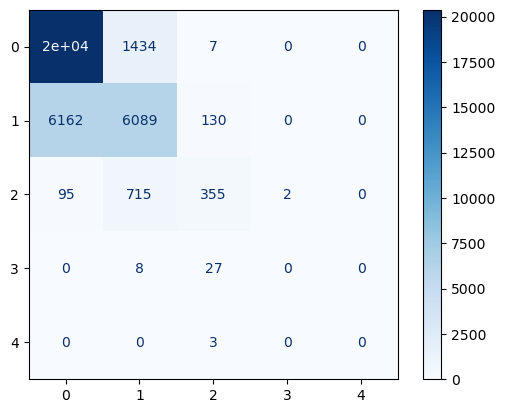

In [232]:
# conf_matrix = evaluate_with_confusion_matrix(model, test_loader, criterion)

In [66]:
def evaluate_regression_metrics(model, test_loader, criterion): 
    model.eval() 
    total_loss = 0.0 
    all_targets = [] 
    all_predictions = [] 

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass
            outputs = model(inputs) 
            loss = criterion(outputs.squeeze(), targets) 
            total_loss += loss.item() 

            # Collect predictions and targets 
            all_targets.extend(targets.cpu().numpy()) 
            all_predictions.extend(outputs.squeeze().cpu().numpy())
    
    # Calculate metrics
    mse = mean_squared_error(all_targets, all_predictions) 
    mae = mean_absolute_error(all_targets, all_predictions) 
    rmse = np.sqrt(mse) 

    print(f"Test Loss (MSE from criterion): {total_loss/len(test_loader):.4f}")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

    return mse, mae, rmse
    

In [32]:
# Transformer Model
print("For Test Loader: ") 
mse, mae, rmse = evaluate_regression_metrics(model, test_loader, criterion)
print("For Train Loader: ") 
mse, mae, rmse = evaluate_regression_metrics(model, test_loader, criterion)

For Test Loader: 
Test Loss (MSE from criterion): 0.0076
Mean Squared Error (MSE): 0.0076
Mean Absolute Error (MAE): 0.0644
Root Mean Squared Error (RMSE): 0.0872
For Train Loader: 
Test Loss (MSE from criterion): 0.0076
Mean Squared Error (MSE): 0.0076
Mean Absolute Error (MAE): 0.0644
Root Mean Squared Error (RMSE): 0.0872


In [68]:
# LSTM Model 
mse, mae, rmse = evaluate_regression_metrics(lstm_model, LSTM_test_loader, criterion)

C:\Users\chamr\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Test Loss (MSE from criterion): 0.0206
Mean Squared Error (MSE): 0.0088
Mean Absolute Error (MAE): 0.0731
Root Mean Squared Error (RMSE): 0.0937


C:\Users\chamr\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([13, 1])) that is different to the input size (torch.Size([13])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


## Evaluate using Test Dataset

In [239]:
# Path to directory 
file_path = 'pre_process_testing_dataset.csv' 

test_dataset = pd.read_csv(file_path) 
test_dataset.head()

,p_num,hour,minute,hour_sin,hour_cos,minute_sin,minute_cos,bg-5:55,bg-5:50,bg-5:45,...,activity-0:40,activity-0:35,activity-0:30,activity-0:25,activity-0:20,activity-0:15,activity-0:10,activity-0:05,activity-0:00,bg+1:00
0,0,6,45,1.000000,6.123234e-17,-1.000000e+00,-1.836970e-16,0.375587,0.273438,0.294667,...,2,8,2,2,2,2,8,8,2,NaN
1,0,11,25,0.258819,-9.659258e-01,5.000000e-01,-8.660254e-01,0.207389,0.263021,0.292000,...,2,8,2,2,2,2,17,17,17,NaN
2,0,14,45,-0.500000,-8.660254e-01,-1.000000e+00,-1.836970e-16,0.117371,0.128906,0.094667,...,2,8,2,2,2,2,8,8,2,NaN
3,0,4,30,0.866025,5.000000e-01,5.665539e-16,-1.000000e+00,0.068858,0.046875,0.185333,...,2,8,2,2,2,2,8,8,2,NaN
4,0,4,20,0.866025,5.000000e-01,8.660254e-01,-5.000000e-01,0.239232,0.369792,0.228000,...,2,8,2,2,2,2,8,8,2,NaN


In [241]:
# Retrieve participant id 
imputed_file_path = 'combined_test_batch_imputed.csv' 

imputed_file = pd.read_csv(imputed_file_path) 

final_result = imputed_file[['id']] 
print(final_result.head())

         id
0  p01_8459
1  p01_8460
2  p01_8461
3  p01_8462
4  p01_8463


In [243]:
# Define the target column 
target_col = 'bg+1:00' 

# Separate input features (all columns except the target) 
X_eval = test_dataset.drop(columns=[target_col]).values # input features as NumPy array 

# Separate output feature (target column) 
y_eval = test_dataset[target_col].values # Target as NumPy array 

In [245]:
class TransformerDatasetEval(Dataset):
    def __init__(self, inputs):
        self.inputs = torch.tensor(inputs, dtype=torch.float32)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx]


In [247]:
# Create PyTorch datasets 
eval_dataset = TransformerDatasetEval(X_eval) 
eval_loader = DataLoader(eval_dataset, batch_size=32, shuffle=False) 

In [271]:
def predict_bg_plus_one(model, data_loader): 
    model.eval()
    predictions = [] 

    with torch.no_grad(): 
        for inputs in data_loader: 
            if isinstance(inputs, list): 
                inputs = torch.tensor(inputs, dtype=torch.float32) 
                
            # Move inputs to the same device as the model        
            inputs = inputs.to(device)

            # Forward pass
            outputs = model(inputs).squeeze()
            predictions.extend(outputs.cpu().numpy()) # Collect predictions
    
    return predictions

In [277]:
# Generate predictions
predictions = predict_bg_plus_one(model, eval_loader)

# Convert predictions back to the original scale using the loaded scaler 
scaler = joblib.load('training_bg_prediction_scaler.pkl') 
print("Scaler loaded from 'training_bg_prediction_scaler.pkl'")

print("Scaler parameters:")
print("Min:", scaler.data_min_)
print("Max:", scaler.data_max_)
print("Scale:", scaler.scale_)

print("Training bg+1:00 min:", dataset['bg+1:00'].min())
print("Training bg+1:00 max:", dataset['bg+1:00'].max())

predictions_original_values = scaler.inverse_transform(np.array(predictions).reshape(-1,1))

# Add predictions to final_result Dataframe
final_result['bg+1:00'] = predictions_original_values.flatten()

# Save final_result Dataframe to CSV file 
final_result.to_csv('final_result_with_predictions.csv', index=False)
print("Final results saved to 'final_result_with_predictions.csv'") 

Scaler loaded from 'training_bg_prediction_scaler.pkl'
Scaler parameters:
Min: [2.2]
Max: [27.8]
Scale: [0.0390625]
Training bg+1:00 min: 0.0
Training bg+1:00 max: 1.0
Final results saved to 'final_result_with_predictions.csv'


C:\Users\chamr\AppData\Local\Temp\ipykernel_17928\4021755084.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_result['bg+1:00'] = predictions_original_values.flatten()
